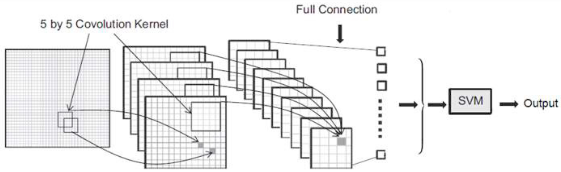

# Classification foliar diseases in apple trees

## Import Packages

In [154]:
# !pip install xgboost
# # 대규모의 구조화된 데이터에 대한 예측 및 분류 작업에 사용
# # 분류, 회귀, 피처 중요도 추출, 결측값 처리, 앙상블 및 스태킹

In [155]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

## Preprocessing Dataset Images

In [156]:
dataset_folder = os.path.join("./data/")
# os.path.join(): 경로를 결합하여 새 경로 생성

In [157]:
# 데이터 불러오기
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [158]:
# 이미지 데이터셋폴더의 전체 경로 생성 후 할당
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
# 경로에 있는 모든 이미지 파일을 찾아서 리스트로 변환
listImages = list(imagesDataset.glob("*.*"))
# pathlib.Path(): 경로를 다루기 위한 클래스
# glob(): 경로 패턴을 사용하여 해당 패턴과 일치하는 파일 찾음

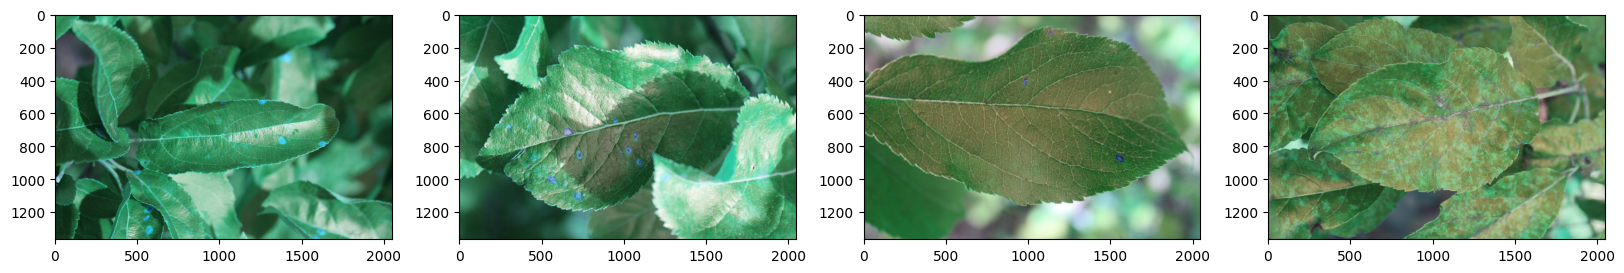

In [159]:
# 시각화
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [160]:
datasetObject.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [161]:
# 각 열 데이터 저장
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [162]:
images_id_csv

0          Train_0
1          Train_1
2          Train_2
3          Train_3
4          Train_4
           ...    
1816    Train_1816
1817    Train_1817
1818    Train_1818
1819    Train_1819
1820    Train_1820
Name: image_id, Length: 1821, dtype: object

In [163]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))  # 이미지 파일 로드
    img = cv2.resize(img, (100, 100)) # 이미지 크기 조정
    # Rescaling
    img = img / 255 # 이미지 데이터 정규화
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                    scab_csv[index]])
    # 각 열 값으로 label 생성하여 리스트에 추가
    images.append(img) # 전처리한 이미지 리스트에 추가

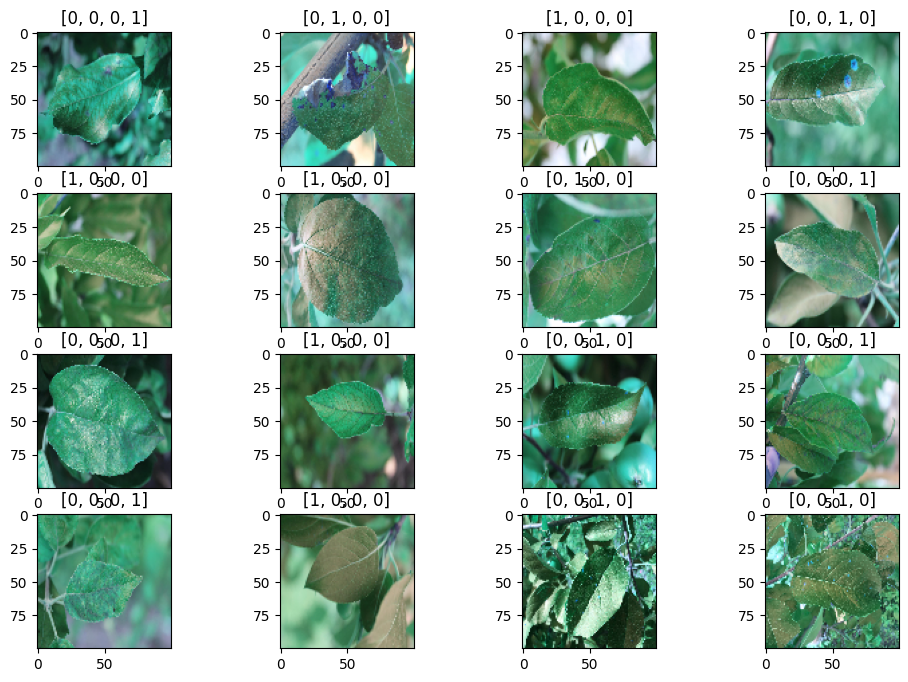

In [164]:
# 시각화
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [165]:
# 데이터 증강
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,                # 이미지 회전 범위(0.35 라디안)
        zoom_range=0.2,                     # 이미지 확대/축소 범위 (0.2배)
        horizontal_flip=True,               # 수평 방향 뒤집기
        vertical_flip=True,                 # 수직 방향 뒤집기
        shear_range=0.2,                    # 이미지 전단 변환 범위 (0.2 라디안)
        width_shift_range=0.15,             # 이미지 가로 이동 범위 (전체 너비의 0.15 비율)
        height_shift_range=0.15,            # 이미지 세로 이동 범위 (전체 높이의 0.15 비율)
        rescale=None                        # 스케일링 적용 안 함
)

## Images Data Augentation

In [166]:
# 증강 적용 후 이미지와 라벨 저장
images_after_aug = []
labels_after_aug = []
# 이미지 리스트의 인덱스와 값 반복
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      # 이미지 데이터 증강
      # 이미지 형태를 (1, 100, 100, 3)으로 변경하여 generator에 입력
      # next(): 다음 증강된 이미지 가져옴
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      # 증강된 이미지를 다시 변형하여 리스트에 추가
      labels_after_aug.append(labels[index])
      # 해당 이미지의 라벨을 가져와 리스트에 추가
labels = np.asarray(labels_after_aug) # 리스트를 numpy배열로 변환
images = np.asarray(images_after_aug) # 리스트를 numpy배열로 변환
# array(): copy=True가 기본값
# asarray(): copy=False가 기본값
# >> array는 객체의 복사본을 생성하지만 asarray는 필요하지 않을 때 생성하지 않음

In [167]:
labels.shape

(16389, 4)

In [168]:
images.shape

(16389, 100, 100, 3)

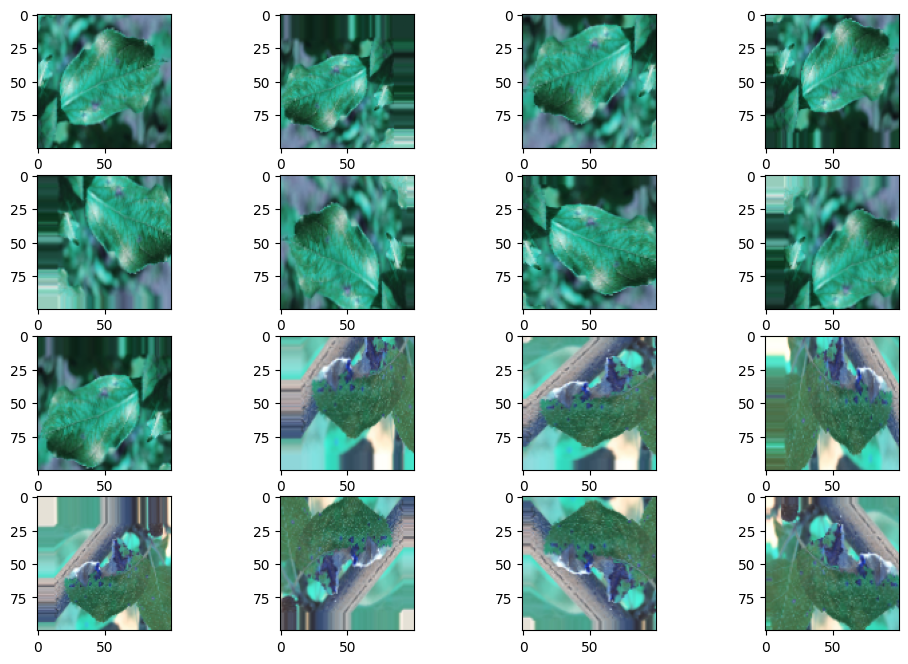

In [169]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  # plt.title(labels[i])
plt.show()

## Build Model

In [170]:
# DenseNet121 아키텍처 생성
d = tf.keras.applications.DenseNet121(include_top=False,  # 모델의 맨 위에 있는 fully connected layer를 제외하고 가져옴
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet'       # ImageNet 데이터셋에서 사전 학습된 가중치를 사용
                   )
for i in d.layers:
  i.trainable = True
# 사전 학습된 가중치를 업데이트할 수 있도록 모든 레이어를 학습 가능하게 만든다.

In [171]:
from tensorflow.keras import regularizers
# DenseNet121모델의 출력을 전역 평균 풀링 레이어를 사용하여 변환
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output) 
# DenseNet121모델의 출력을 전역 최대 풀링 레이어를 사용하여 변환
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)  
# 두 개의 풀링 레이어릐 출력을 최소값으로 결합하여 저장    
m = tf.keras.layers.minimum([output_avg, output_max])     
# 과적합 방지       
m = tf.keras.layers.Dropout(0.5)(m)                              
# ReLU 활성화 함수를 가진 fully connected 레이어 추가
m = tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=regularizers.l2(0.01))(m)        
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer=regularizers.l2(0.01))(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu", kernel_regularizer=regularizers.l2(0.01))(m)
m = tf.keras.layers.Dropout(0.3)(m)
# softmax 활성화 함수를 가진 fully connected 레이어 추가
m = tf.keras.layers.Dense(4, activation= "softmax", kernel_regularizer=regularizers.l2(0.01))(m)   

# DenseNet121 모델의 입력과 m의 출력을갖는 모델 생성
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
            # 손실 함수
            loss = "categorical_crossentropy", 
            # 성능 평가 기준
            metrics =["accuracy", 
                    Precision(name='precision'), 
                    Recall(name='recall')])
m.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 106, 106, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                            

In [172]:
# 학습용/평가용 데이터 셋 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [173]:
x_train.shape

(13930, 100, 100, 3)

In [174]:
x_test.shape

(2459, 100, 100, 3)

In [175]:
y_train.shape

(13930, 4)

In [176]:
y_test.shape

(2459, 4)

In [177]:
x_train.min(), x_train.max()

(0.0, 1.0)

In [178]:
x_test.min(), x_test.max()

(0.0, 1.0)

## Train Model

In [179]:
# 모델 훈련
history = m.fit(x_train, y_train, epochs = 100, batch_size = 32,
                validation_data=(x_test, y_test),   # 검증 데이터
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min', patience= 1),
                    # (리듀스 엘알온 플레토) : 훈련 과정 중에 학습률을 동적으로 조정 (지정된 지표(metric)의 동작에 따라 학습률을 조정하는 데 사용)
                
                    # monitor : 콜백은 훈련 손실(loss)을 모니터링함
                    # 특정 요구에 따라 검증 손실(validation loss)이나 정확도 등 다른 지표를 선택할 수도 있음
                    # factor : 학습률을 얼마나 감소시킬지 결정 / 학습률을 조정하기 위한 곱셈 요소로 작용하며, 지정된 비율만큼 학습률을 줄임 --> 개선되지 않을 때 0.1(10%)감소
                    # 모니터링 대상을 최소화할지 최대화할지를 지정
                    # 'min', 'max', 'auto' 중 하나로 설정할 수 있음
                    # 예제에서는 'min'으로 설정되어 있으므로, 손실을 최소화해야 함을 의미
                    # patience : 개선이 없을 때 종료를 기다리는 에포크(epoch) 수를 결정
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])  # restore_best_weights: Earlystopping으로 조기 종료 후, 최상의 성능을 가지는 모델의 가중치를 복원할지 여부를 결정함
                    # 예제에서는 True로 설정되어 있으므로, 조기 종료 시점에서의 최상의 성능을 가진 모델의 가중치가 복원됨
                    
# history >> 훈련 과정에서 발생한 손실과 정확도의 추이 저장

Epoch 1/100
436/436 [==============================] - 43s 71ms/step - loss: 2.7154 - accuracy: 0.6622 - precision: 0.8036 - recall: 0.5159 - val_loss: 0.9315 - val_accuracy: 0.7011 - val_precision: 0.7958 - val_recall: 0.6275 - lr: 0.0010
Epoch 2/100
436/436 [==============================] - 30s 68ms/step - loss: 0.5506 - accuracy: 0.8744 - precision: 0.9013 - recall: 0.8436 - val_loss: 0.4599 - val_accuracy: 0.8764 - val_precision: 0.8977 - val_recall: 0.8532 - lr: 0.0010
Epoch 3/100
436/436 [==============================] - 30s 69ms/step - loss: 0.3859 - accuracy: 0.9044 - precision: 0.9298 - recall: 0.8856 - val_loss: 0.4473 - val_accuracy: 0.8849 - val_precision: 0.8992 - val_recall: 0.8739 - lr: 0.0010
Epoch 4/100
436/436 [==============================] - 59s 136ms/step - loss: 0.3218 - accuracy: 0.9184 - precision: 0.9410 - recall: 0.9021 - val_loss: 0.9159 - val_accuracy: 0.7263 - val_precision: 0.7535 - val_recall: 0.6938 - lr: 0.0010
Epoch 5/100
436/436 [==================

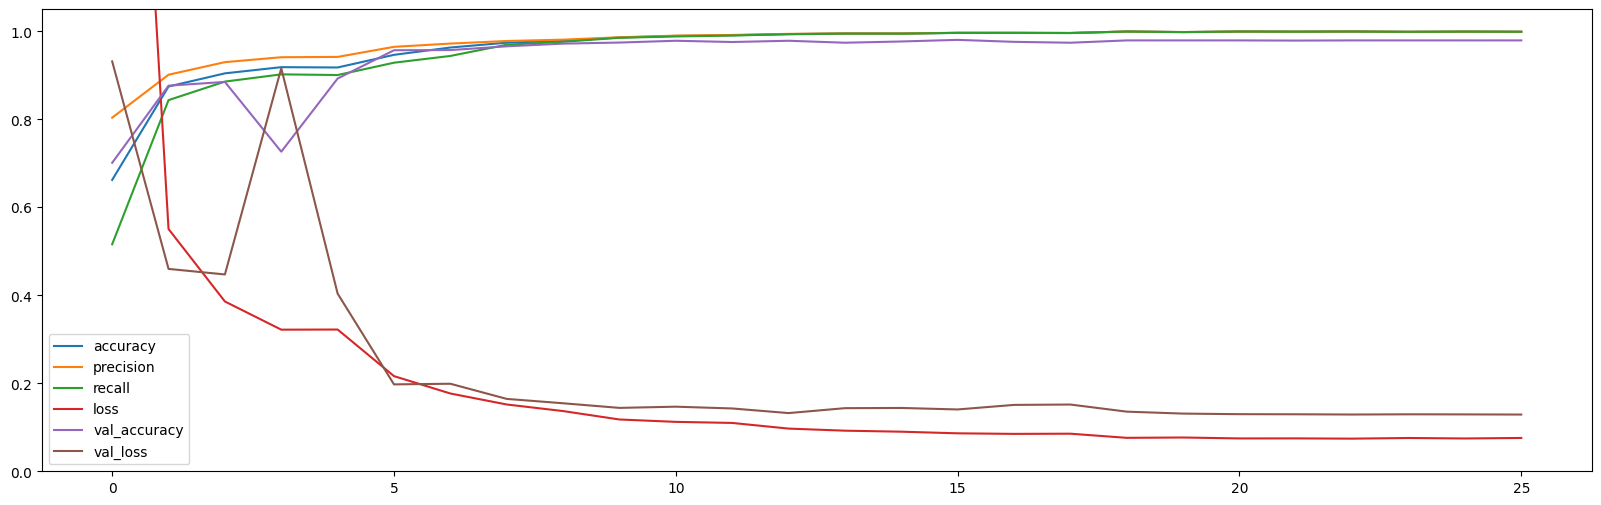

In [180]:
# 훈련 과정에서 발생한 손실, 정확도, 정밀도, 재현율, 검증 손실, 검증 정확도 시각화
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.ylim(0, 1.05)  # y 축 범위를 0부터 1.05으로 설정
plt.legend()
plt.show()

## 추론

In [181]:
import cv2
# 이미지 처리를 위해 openCV 라이브러리

test_set = pd.read_csv("./data/test.csv", index_col=0)
# 테스트 데이터 불러오기
# 인덱스 열 : 0번 열로 설정 : 데이터프레임의 행을 구분하기 위함

SOURCE = 'data/images/'
# 경로 저장 --> 이미지 파일들이 있는 디렉토리 경로

X_test = []  # 테스트 이미지를 저장할 리스트
for index, data in test_set.iterrows():
    # iterrows() : test_set 데이터프레임을 반복하면서 각행의 index와 data를 한번에 가져옴
    filepath = os.path.join(SOURCE, index + ".jpg")
    # SOURCE 경로와 index 값을 결합하여 이미지 파일의 경로 생성
    # index 값은 각 행의 인덱스 값이며, jpg 확장자를 추가함
    img = plt.imread(filepath).astype("float32")
    # filepath 경로의 이미지 파일을 읽어옴
    # --> float32 데이터 타입으로 변환
    
    # img = ./255 --> 앞선 코드인 image, label을 만드는 과정에서 Rescaling 했음
    
    img = cv2.resize(img, dsize=(100, 100))
    # 이미지 크기를 (100,100) 조정하여 일정한 크기로 통일시킴
    X_test.append(img)
    # 처리된 img를 x_test 리스트에 추가
X_test = np.stack(X_test)
# np.stack() : 리스트에 저장된 이미지들을 하나의 배열로 변환
# --> 이미지 데이터를 담고 있는 다차원 배열이 됨

In [182]:
X_test = X_test / 255
# 시행착오
# 데이터 정규화 과정에서 x_test 배열의 모든 요소가 0과 1사이의 값으로 조정되었는지 확인
# 앞선 코드는 train 데이터만 Rescaling 되었고 test 데이터는 그러지 않았음
# --> 코드를 돌렸을 때, 훈련용 데이터셋 성능이 월등하게 높았던 반면,
#     검증용 데이터셋 성능이 낮았던 이유를 찾음

In [183]:
X_test.min(), X_test.max()
# 최솟값과 최댓값이 0 ~ 1 사이임을 재차 확인함

(0.0, 1.0)

In [184]:
with tf.device("GPU"):
    predict = m.predict(X_test, batch_size=32)

# tf.device() : GPU를 사용할 수 있게 장치 지정
# GPU를 사용하여 모델(m)의 x_test 예측을 수행
# 한 번에 처리할 batch의 크기를 지정 --> 한 번에 32개의 입력 데이터를 처리

57/57 [==============================] - 2s 19ms/step


In [185]:
predict
# 예측 결과
# 각 행 : 입력 데이터 예측결과 , 각 열 : 클래스 예측 확률
# 4개의 클래스(labels)가 있으며 4개의 예측 확률이 제공됨
# 예측 확률 --> 0 ~ 1 사이 값으로 표현
# 해당 클래스일 확률이 높을 수록 인덱스의 값이 커짐

# 해석하기
# e = 10의 지수 --> ex) 4.6885987e-03 = 소수점 3자리 앞으로~

array([[4.4547278e-03, 2.9308632e-01, 2.0348628e-04, 7.0225543e-01],
       [3.1436986e-04, 4.3552290e-03, 1.7254776e-07, 9.9533033e-01],
       [2.2660273e-05, 8.5681968e-04, 1.4492424e-09, 9.9912053e-01],
       ...,
       [2.4503021e-04, 3.7306126e-03, 1.0951005e-07, 9.9602425e-01],
       [7.4475110e-01, 2.6143558e-02, 5.3440607e-03, 2.2376131e-01],
       [1.7721787e-03, 1.4420287e-01, 2.8320183e-05, 8.5399669e-01]],
      dtype=float32)

In [186]:
pd.Series(predict.argmax(axis=1)).value_counts().sort_index()
# predict 배열에서 각 예측 결과의 최댓값을 갖는 인덱스 추출
# axis=1 : 행 방향으로 최댓값을 구하는 것을 의미
# --> 예측 결과의 최댓값 인덱스를 담은 배열이 반환됨
# 예측 결과의 최댓값 인덱스가 '값'으로, 해당 예측 결과의 순서가 '인덱스'로 지정됨
# value_counts() : Series 각 값들의 빈도를 계산 (각 클래스 인덱스가 몇 번 나타나는지)
# 빈도 계산 결과를 인덱스 순으로 정렬 --> 각 클래스의 빈도 확인 가능

# 결과적으로 predict 배열에서 각 예측 결과의 클래스 별 빈도를 계산
# 클래스 인덱스 순으로 정렬하여 반환됨  --> 모델이 각 클래스를 얼마나 예측했는지 확인 가능

0     306
1     216
2      79
3    1220
Name: count, dtype: int64

In [187]:
pd.Series(predict.argmax(axis=1)).value_counts()

3    1220
0     306
1     216
2      79
Name: count, dtype: int64

In [188]:
df_out = pd.concat([
    test_set.reset_index(), 
    # 테스트 데이터셋의 인덱스를 초기화(reset_index)한 후,
    # 테스트 데이터셋과 예측 결과를 열 방향으로 결합
    # 예측 결과인 score 배열을 포함하는 데이터프레임을 생성
    pd.DataFrame(predict, columns = ['healthy', 'multiple_diseases', 'rust', 'scab'])
    # 열 이름을 클래스 이름으로 설정
], axis=1)

In [189]:
df_out.to_csv("./test1.csv", index=False)
# csv로 저장
# index=False : 인덱스 열을 csv파일에 포함시키지 않도록 지정
# --> 파일에는 데이터프레임의 열 데이터만 포함

In [190]:
df_out

image_id   healthy  multiple_diseases          rust      scab
0        Test_0  0.004455           0.293086  2.034863e-04  0.702255
1        Test_1  0.000314           0.004355  1.725478e-07  0.995330
2        Test_2  0.000023           0.000857  1.449242e-09  0.999121
3        Test_3  0.001191           0.009865  1.919243e-06  0.988942
4        Test_4  0.738682           0.028925  2.293912e-01  0.003002
...         ...       ...                ...           ...       ...
1816  Test_1816  0.002077           0.027008  8.780116e-06  0.970906
1817  Test_1817  0.000865           0.980070  3.056363e-03  0.016009
1818  Test_1818  0.000245           0.003731  1.095100e-07  0.996024
1819  Test_1819  0.744751           0.026144  5.344061e-03  0.223761
1820  Test_1820  0.001772           0.144203  2.832018e-05  0.853997

[1821 rows x 5 columns]

----------

### Score

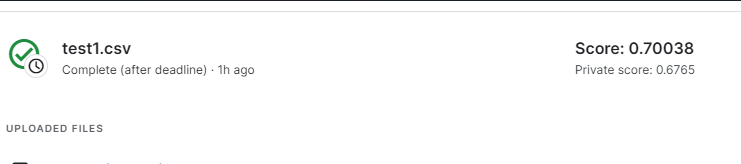